In [3]:
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from transformers import get_linear_schedule_with_warmup

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Parameters
batch_size = 64
num_epochs = 5
num_samples = 10
learning_rate = 0.0005  # learning rate for the gradient descent optimizer, related to the step size

In [4]:
# load the "irony" dataset(name=irony)
cache_dir = "./data_cache_"
subset_name = "irony"

test_dataset = load_dataset(
    "tweet_eval",
    name=subset_name,
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset)} instances loaded")

num_classes_ = np.unique(test_dataset['label']).size

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2862 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/784 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/955 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to ./data_cache_/tweet_eval/irony/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.
Test dataset with 784 instances loaded


In [5]:
# create Tokenizer object
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

# create 'input_ids', 'token_type_ids', 'attention_mask' for train/val/test dataset
def tokenize_function(dataset):
    model_inputs = tokenizer(dataset['text'], padding="max_length", max_length=100, truncation=True)
    return model_inputs

test_dataset_ = test_dataset.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

Build the model

In [6]:
class RoBertaClassifier(nn.Module):
    def __init__(self, freeze_bert, aleatoric_use, num_labels):
        super(RoBertaClassifier, self).__init__()

        # use the pretrained bert model corresponding to the previous tokenizer
        self.aleatoric_use = aleatoric_use
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.config = self.bert.config
    
        # specify the parameter for the classifier
        n_input = self.config.hidden_size
        n_hidden = 50
        p_ = 0.2

        # add dense layers to act as the classifier
        self.classifier = nn.Linear(n_input, n_hidden)

        self.predict = torch.nn.Linear(n_hidden, num_labels)   # predicted output
        self.get_var = torch.nn.Linear(n_hidden, num_labels)   # predicted variance

        # execute when freeze_bert=True
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        else:
            for param in self.bert.parameters():
                param.requires_grad = True
    
    def forward(self, input_ids, attention_mask):
        # get the outputs of the roberta model
        bert_outputs = self.bert(input_ids=input_ids,attention_mask=attention_mask)

        # extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_outputs = bert_outputs[0][:,0,:]

        # Feed input to classifier to compute results(one number for each class)
        x = last_hidden_state_outputs  # 64*768
        x = self.classifier(x)  # 64*50
        x = F.relu(x)  # 64*50
        x = F.dropout(x, p=0.2)  # 64*50
        
        logits = self.predict(x)  # logits layer 64*2
        if self.aleatoric_use:  # consider aleatoric uncertainty --> two sets of output
          sigma = self.get_var(x)  # uncertainty layer 64*2
          return logits, sigma
        else:
          return logits

In [36]:
def apply_dropout(m):
    if type(m) == F.dropout:  # type(m) == nn.Dropout or
        m.train()

# net.eval()
# net.apply(apply_dropout)

In [8]:
# convert dataset to dataloader
batch_size = 1
def convert_to_data_loader(dataset, num_classes):
    # convert from list to tensor
    input_tensor = torch.from_numpy(np.array(dataset['input_ids']))
    label_tensor = torch.from_numpy(np.array(dataset['label'])).long()
    # 'attention_mask' is also taken into consideration when constructing DataLoader(def forward())
    atten_tensor = torch.from_numpy(np.array(dataset['attention_mask']))
    
    tensor_dataset = TensorDataset(input_tensor, atten_tensor, label_tensor)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    return loader

# get all sentences ready for the model
test_loader = convert_to_data_loader(test_dataset_, num_classes_)

In [34]:
def show_with_var(mean_prob, var_prob, mean_uncer):
    """Display single mnist digit next to the variance per class"""
    labels = [str(x) for x in range(num_classes_)]

    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    axs[0].bar(labels, mean_prob, width=0.4)
    axs[0].grid(True, linestyle=':' ,alpha=0.6)
    axs[1].bar(labels, var_prob, width=0.4)
    axs[1].grid(True, linestyle=':' ,alpha=0.6)
    axs[2].bar(labels, mean_uncer, width=0.4)
    axs[2].grid(True, linestyle=':' ,alpha=0.6) # linestyle=':',alpha=0.6, color='r',
    plt.show()

In [16]:
model_path = "./irony_comb_model_bert.pt"
reload_model = torch.load(model_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Correct: [0]
Predicted: [1]
Sentence: So much #sarcasm at work mate 10/10 #boring 100% #dead mate full on #shit absolutely #sleeping mate can't handle the #sarcasm
tensor([[[0.3596, 0.6404]],

        [[0.4393, 0.5607]],

        [[0.4192, 0.5808]],

        [[0.4456, 0.5544]],

        [[0.4669, 0.5331]]], grad_fn=<CopySlices>)


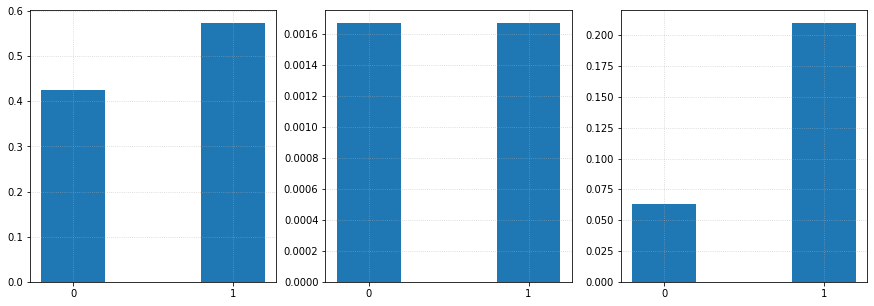

Correct: [0]
Predicted: [1]
Sentence: People complain about my backround pic and all I feel is like "hey don't blame me, Albert E might have spoken those words" #sarcasm #life
tensor([[[0.4551, 0.5449]],

        [[0.3921, 0.6079]],

        [[0.4939, 0.5061]],

        [[0.3604, 0.6396]],

        [[0.4197, 0.5803]]], grad_fn=<CopySlices>)


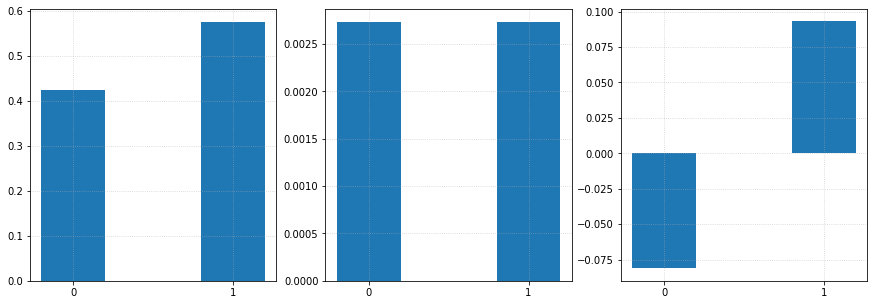

Correct: [0]
Predicted: [1]
Sentence: Most important thing I've learned in school
tensor([[[0.3903, 0.6097]],

        [[0.5090, 0.4910]],

        [[0.4419, 0.5581]],

        [[0.4772, 0.5228]],

        [[0.5017, 0.4983]]], grad_fn=<CopySlices>)


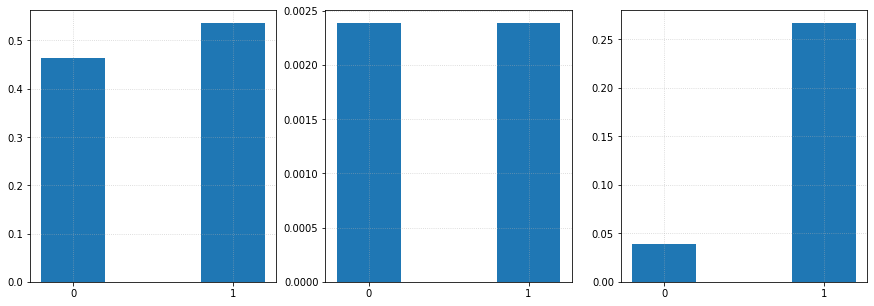

Correct: [1]
Predicted: [0]
Sentence: Oh boy... @user in the house. Warm up the DJ booth @user
tensor([[[0.5586, 0.4414]],

        [[0.5977, 0.4023]],

        [[0.5230, 0.4770]],

        [[0.6627, 0.3373]],

        [[0.5430, 0.4570]]], grad_fn=<CopySlices>)


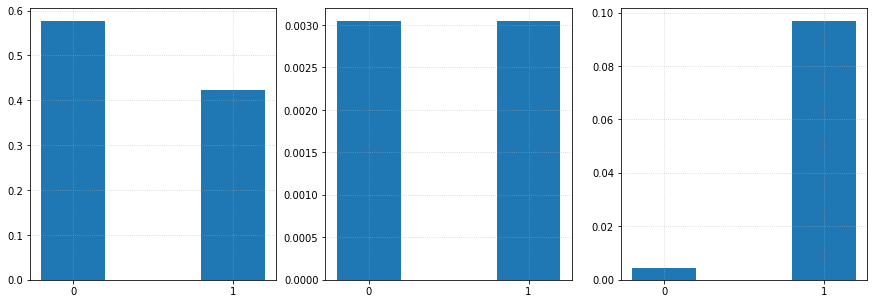

Correct: [1]
Predicted: [0]
Sentence: LIAR, i've never denied the 532 murders in Chicago in 2012 @user @user @user @user @user
tensor([[[0.5645, 0.4355]],

        [[0.5429, 0.4571]],

        [[0.6420, 0.3580]],

        [[0.4554, 0.5446]],

        [[0.4349, 0.5651]]], grad_fn=<CopySlices>)


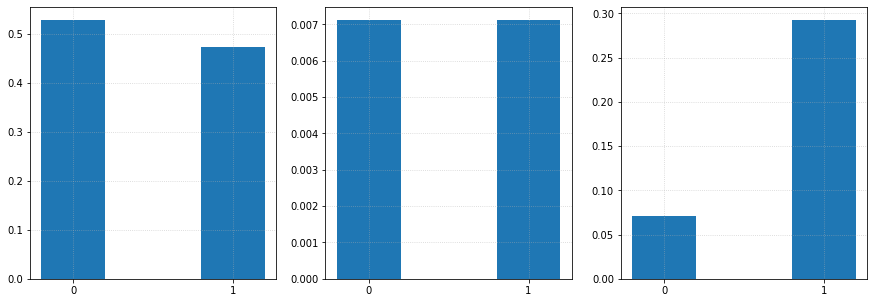

Correct: [1]
Predicted: [0]
Sentence: Always classy, never trashy and just a little sassy.
tensor([[[0.6281, 0.3719]],

        [[0.5931, 0.4069]],

        [[0.5284, 0.4716]],

        [[0.6688, 0.3312]],

        [[0.6105, 0.3895]]], grad_fn=<CopySlices>)


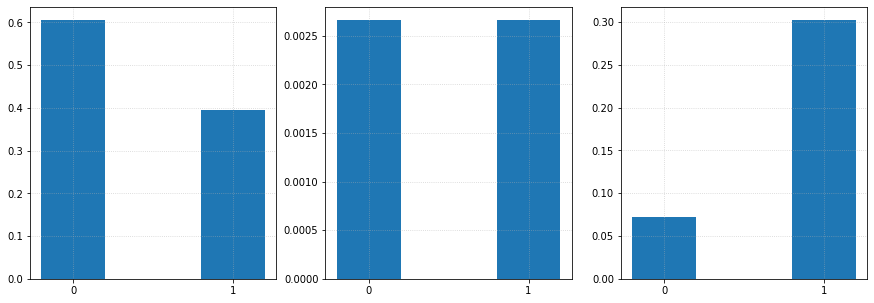

Correct: [1]
Predicted: [0]
Sentence: @user #Not #Long To Go #Before #MainStream #Media #Pitch. #Surgery #follows #with #me #using #Prototype #demonstrating #real #situation.Phil
tensor([[[0.6576, 0.3424]],

        [[0.6262, 0.3738]],

        [[0.6288, 0.3712]],

        [[0.6203, 0.3797]],

        [[0.6938, 0.3062]]], grad_fn=<CopySlices>)


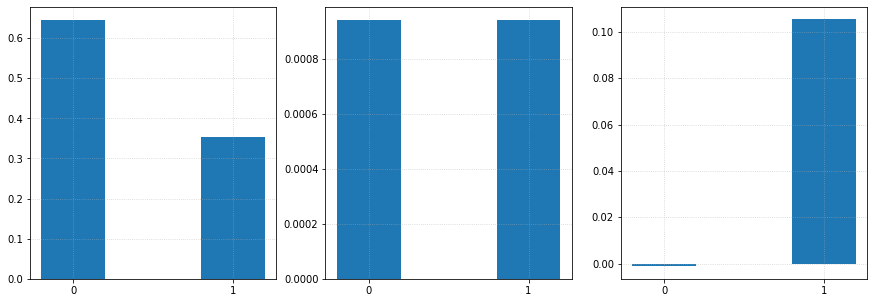

Correct: [1]
Predicted: [0]
Sentence: The definition of #IRONY would be if a 77-year-old rapper went #viral and took #BITCOIN mainstream. Maybe only way #babyboomers will buy in.
tensor([[[0.4962, 0.5038]],

        [[0.5241, 0.4759]],

        [[0.5099, 0.4901]],

        [[0.6107, 0.3893]],

        [[0.4741, 0.5259]]], grad_fn=<CopySlices>)


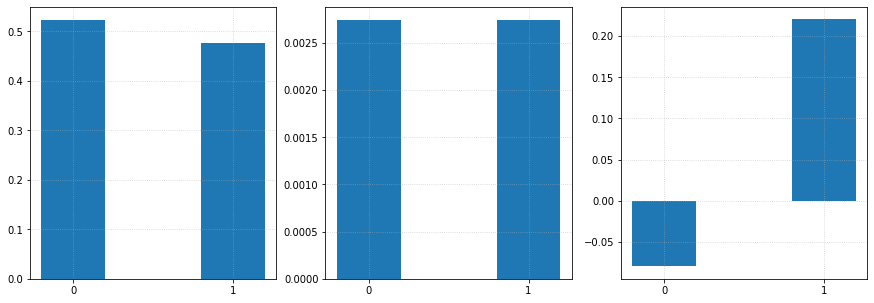

Correct: [1]
Predicted: [0]
Sentence: Pretty excited about how you gave up on me. File Under: #sarcasm
tensor([[[0.5200, 0.4800]],

        [[0.5551, 0.4449]],

        [[0.5888, 0.4112]],

        [[0.5088, 0.4912]],

        [[0.5283, 0.4717]]], grad_fn=<CopySlices>)


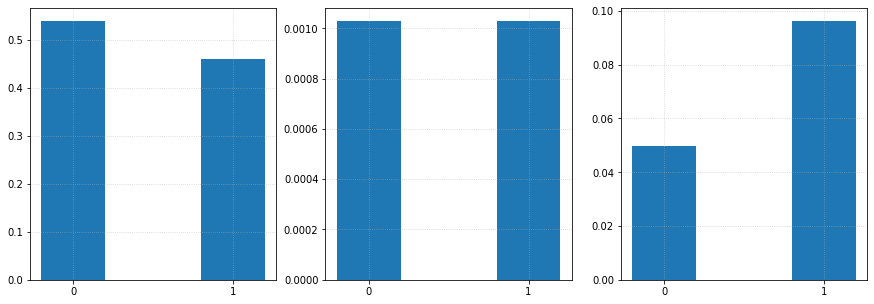

Correct: [1]
Predicted: [0]
Sentence: @user hmm... let me think about that #sarcasm
tensor([[[0.6745, 0.3255]],

        [[0.6611, 0.3389]],

        [[0.7401, 0.2599]],

        [[0.6766, 0.3234]],

        [[0.6157, 0.3843]]], grad_fn=<CopySlices>)


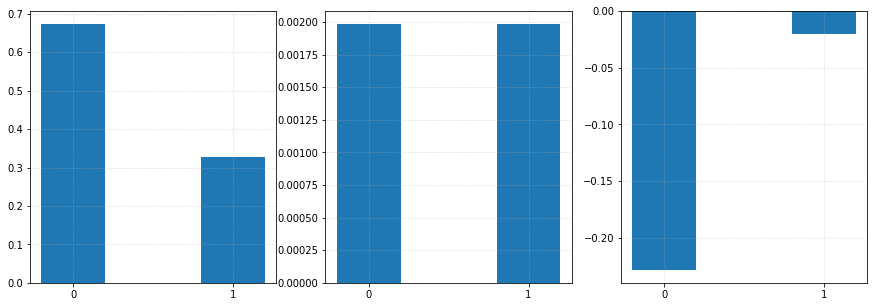

In [35]:
reload_model.eval() # Switch model to evaluation mode 
reload_model.apply(apply_dropout) # Keep the dropout layer open when testing

correct = 0  # count the number of correct classification labels
nwrongs = 0

gold_labs = []  # gold labels to return
pred_labs = []  # predicted labels to return
    
index = -1
for inputs, atten, labels in test_loader:
    index += 1
    test_prob_total = torch.zeros((5, labels.size(0), num_classes_))
    for i in range(5):
        test_mu, test_sigma = reload_model(inputs, atten)
        test_prob = F.softmax(test_mu)
        test_prob_total[i]=test_prob
    test_prob_avg = torch.mean(test_prob_total, 0)
    test_prob_var = torch.var(test_prob_total, 0)
    test_sigma_avg = torch.mean(test_sigma, 0)
      
    # take the label with biggest output as the predicted label
    predicted_labels = torch.max(test_prob_avg, 1)[1].data.numpy().tolist()
    gold_labs = labels.tolist()
    
    if nwrongs < 10:
        if predicted_labels != gold_labs:
            nwrongs += 1
            print("Correct: " + str(gold_labs))
            print("Predicted: " + str(predicted_labels))
            print("Sentence: "+str(test_dataset[index]['text']))
            print(test_prob_total)
            # print(test_prob_avg.detach().numpy()[0])
            # print(test_prob_var.detach().numpy()[0])
            # print(test_sigma_avg.detach().numpy())
            show_with_var(test_prob_avg.detach().numpy()[0],
                   test_prob_var.detach().numpy()[0],
                   test_sigma_avg.detach().numpy())

In [37]:
# load the "emotion" dataset
cache_dir = "./data_cache_"
subset_name = "emotion"

test_dataset = load_dataset(
    "tweet_eval",
    name=subset_name,
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset)} instances loaded")

num_classes_ = np.unique(test_dataset['label']).size

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3257 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1421 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/374 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to ./data_cache_/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.
Test dataset with 1421 instances loaded


In [38]:
# create Tokenizer object
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

# create 'input_ids', 'token_type_ids', 'attention_mask' for train/val/test dataset
def tokenize_function(dataset):
    model_inputs = tokenizer(dataset['text'], padding="max_length", max_length=100, truncation=True)
    return model_inputs

test_dataset_ = test_dataset.map(tokenize_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [39]:
# convert dataset to dataloader
batch_size = 1
def convert_to_data_loader(dataset, num_classes):
    # convert from list to tensor
    input_tensor = torch.from_numpy(np.array(dataset['input_ids']))
    label_tensor = torch.from_numpy(np.array(dataset['label'])).long()
    # 'attention_mask' is also taken into consideration when constructing DataLoader(def forward())
    atten_tensor = torch.from_numpy(np.array(dataset['attention_mask']))
    
    tensor_dataset = TensorDataset(input_tensor, atten_tensor, label_tensor)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    return loader

# get all sentences ready for the model
test_loader = convert_to_data_loader(test_dataset_, num_classes_)

In [42]:
model_path = "./emotion_com_model_.pt"
reload_model = torch.load(model_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Correct: [3]
Predicted: [0]
Sentence: My visit to hospital for care triggered #trauma from accident 20+yrs ago and image of my dead brother in it. Feeling symptoms of #depression
tensor([[[0.2798, 0.2564, 0.0514, 0.4124]],

        [[0.4808, 0.2850, 0.0374, 0.1968]],

        [[0.4470, 0.3078, 0.0309, 0.2143]],

        [[0.3664, 0.3572, 0.0325, 0.2439]],

        [[0.2641, 0.4559, 0.0341, 0.2459]]], grad_fn=<CopySlices>)


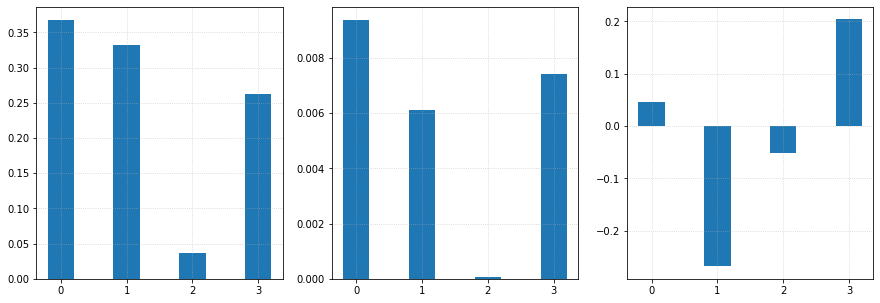

Correct: [0]
Predicted: [1]
Sentence: In need of a change! #restless
tensor([[[0.3732, 0.5215, 0.0637, 0.0416]],

        [[0.1619, 0.7614, 0.0412, 0.0355]],

        [[0.2965, 0.5918, 0.0494, 0.0623]],

        [[0.2755, 0.6026, 0.0455, 0.0764]],

        [[0.3926, 0.5097, 0.0577, 0.0400]]], grad_fn=<CopySlices>)


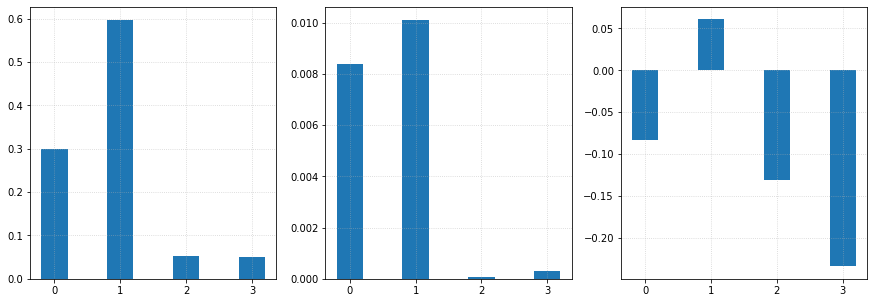

Correct: [1]
Predicted: [2]
Sentence: @user Get Donovan out of your soccer booth. He's awful. He's bitter. He makes me want to mute the tv. #horrid
tensor([[[0.3126, 0.2000, 0.2609, 0.2265]],

        [[0.1968, 0.2441, 0.3730, 0.1861]],

        [[0.1857, 0.2158, 0.3981, 0.2004]],

        [[0.1729, 0.3471, 0.2250, 0.2549]],

        [[0.3286, 0.2195, 0.2370, 0.2150]]], grad_fn=<CopySlices>)


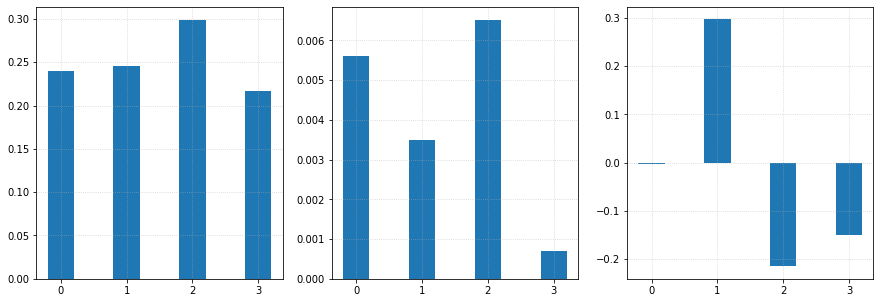

Correct: [0]
Predicted: [1]
Sentence: Comparing yourself to others is one of the root causes for feelings of unhappiness and depression.
tensor([[[0.0624, 0.6104, 0.0449, 0.2824]],

        [[0.0696, 0.6929, 0.0204, 0.2171]],

        [[0.1379, 0.6560, 0.0525, 0.1536]],

        [[0.0826, 0.4096, 0.0357, 0.4721]],

        [[0.0911, 0.6768, 0.0342, 0.1979]]], grad_fn=<CopySlices>)


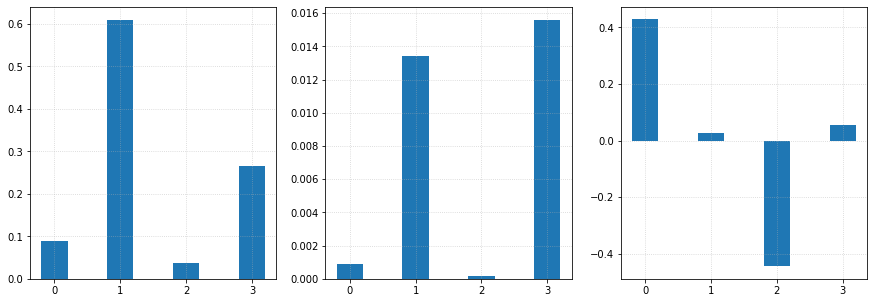

Correct: [3]
Predicted: [0]
Sentence: I love swimming for the same reason I love meditating...the feeling of weightlessness.
tensor([[[0.5525, 0.2226, 0.0242, 0.2007]],

        [[0.5035, 0.1556, 0.0308, 0.3101]],

        [[0.5129, 0.1738, 0.0548, 0.2585]],

        [[0.6357, 0.1770, 0.0234, 0.1639]],

        [[0.5337, 0.1778, 0.0291, 0.2594]]], grad_fn=<CopySlices>)


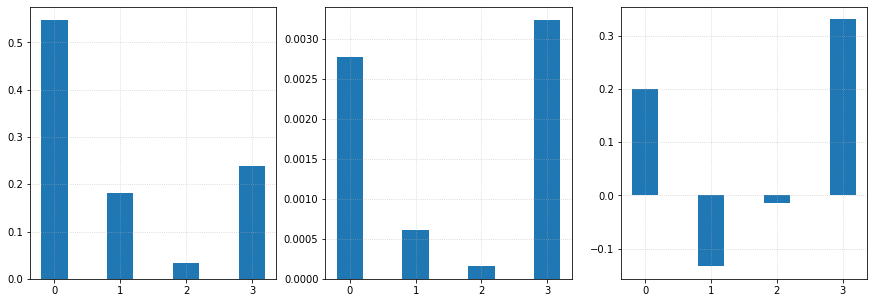

Correct: [0]
Predicted: [3]
Sentence: @user Is it just me that thinks it looks boring?
tensor([[[0.1347, 0.1998, 0.1515, 0.5139]],

        [[0.1416, 0.2039, 0.1521, 0.5024]],

        [[0.1792, 0.2058, 0.1592, 0.4558]],

        [[0.2161, 0.3087, 0.1112, 0.3639]],

        [[0.1350, 0.2659, 0.1406, 0.4585]]], grad_fn=<CopySlices>)


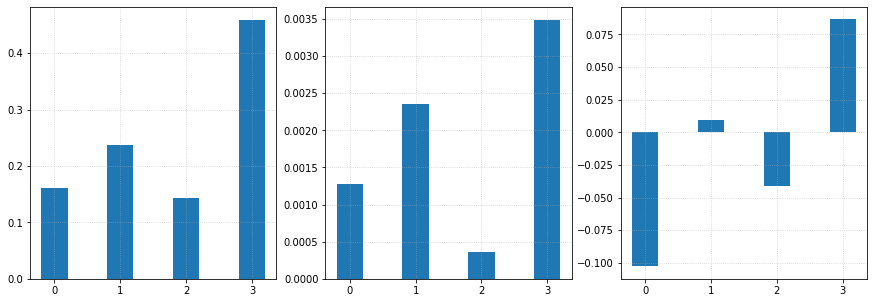

Correct: [2]
Predicted: [0]
Sentence: @user Really??? I've had to hang up!
tensor([[[0.5780, 0.0384, 0.2535, 0.1301]],

        [[0.6904, 0.0571, 0.1600, 0.0925]],

        [[0.5229, 0.1052, 0.2264, 0.1454]],

        [[0.6445, 0.0698, 0.1570, 0.1286]],

        [[0.6375, 0.0906, 0.1443, 0.1277]]], grad_fn=<CopySlices>)


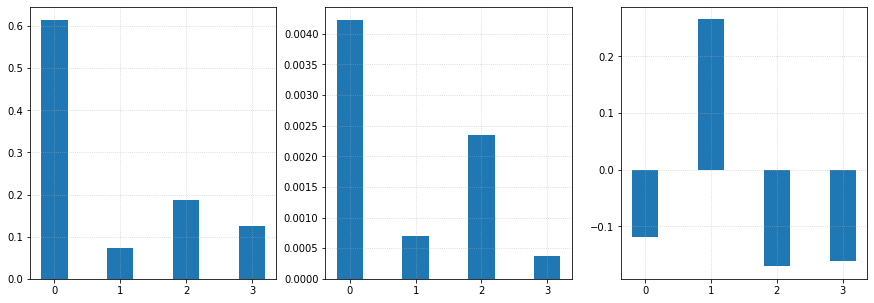

Correct: [0]
Predicted: [1]
Sentence: yukwon no video do zico the world is shaking
tensor([[[0.2497, 0.4190, 0.1361, 0.1953]],

        [[0.4369, 0.2463, 0.1046, 0.2123]],

        [[0.3073, 0.2379, 0.1450, 0.3098]],

        [[0.3370, 0.2826, 0.1032, 0.2772]],

        [[0.2290, 0.4262, 0.1160, 0.2289]]], grad_fn=<CopySlices>)


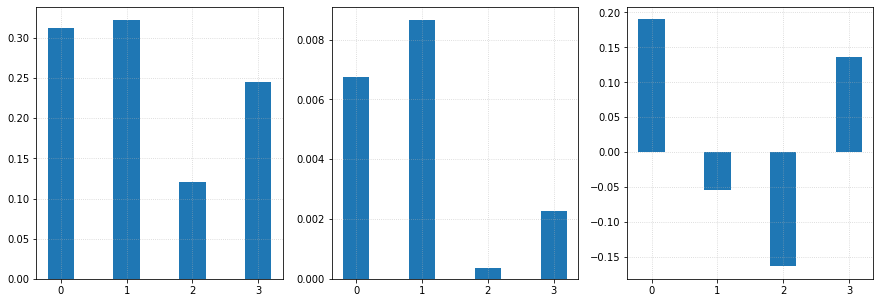

Correct: [1]
Predicted: [2]
Sentence: @user - spelled exactly how it makes you feel 'better eat land line'. Talking to my mom this week has been impossible. #goodservice #rage
tensor([[[0.3029, 0.1805, 0.2696, 0.2470]],

        [[0.4367, 0.0834, 0.3510, 0.1289]],

        [[0.2162, 0.1581, 0.3887, 0.2369]],

        [[0.3269, 0.1888, 0.3605, 0.1238]],

        [[0.3357, 0.1398, 0.3813, 0.1432]]], grad_fn=<CopySlices>)


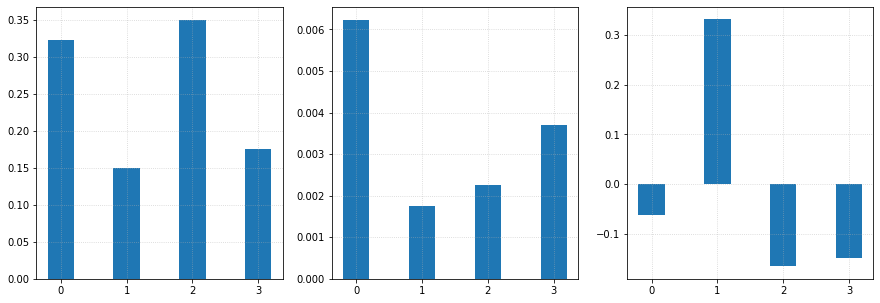

Correct: [0]
Predicted: [3]
Sentence: @user @user Agree with @user or you are of a lower intelligence would be your message there then? #dreadful
tensor([[[0.1461, 0.3037, 0.0384, 0.5118]],

        [[0.0908, 0.3751, 0.0330, 0.5011]],

        [[0.2117, 0.4569, 0.0649, 0.2664]],

        [[0.1869, 0.3494, 0.1326, 0.3311]],

        [[0.1410, 0.4361, 0.0291, 0.3939]]], grad_fn=<CopySlices>)


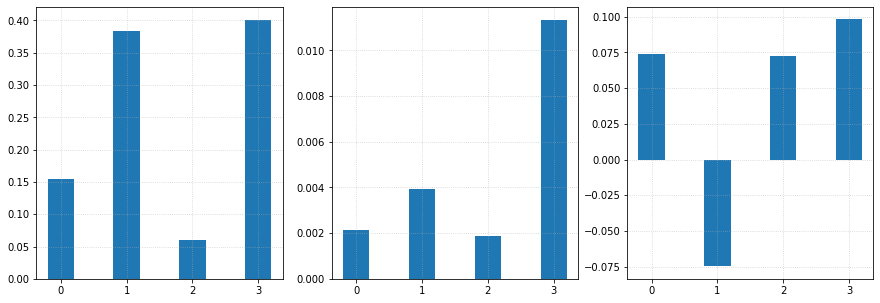

In [43]:
reload_model.eval() # Switch model to evaluation mode 
reload_model.apply(apply_dropout) # Keep the dropout layer open when testing

correct = 0  # count the number of correct classification labels
nwrongs = 0

gold_labs = []  # gold labels to return
pred_labs = []  # predicted labels to return
    
index = -1
for inputs, atten, labels in test_loader:
    index += 1
    test_prob_total = torch.zeros((5, labels.size(0), num_classes_))
    for i in range(5):
        test_mu, test_sigma = reload_model(inputs, atten)
        test_prob = F.softmax(test_mu)
        test_prob_total[i]=test_prob
    test_prob_avg = torch.mean(test_prob_total, 0)
    test_prob_var = torch.var(test_prob_total, 0)
    test_sigma_avg = torch.mean(test_sigma, 0)
      
    # take the label with biggest output as the predicted label
    predicted_labels = torch.max(test_prob_avg, 1)[1].data.numpy().tolist()
    gold_labs = labels.tolist()
    
    if nwrongs < 10:
        if predicted_labels != gold_labs:
            nwrongs += 1
            print("Correct: " + str(gold_labs))
            print("Predicted: " + str(predicted_labels))
            print("Sentence: "+str(test_dataset[index]['text']))
            print(test_prob_total)
            # print(test_prob_avg.detach().numpy()[0])
            # print(test_prob_var.detach().numpy()[0])
            # print(test_sigma_avg.detach().numpy())
            show_with_var(test_prob_avg.detach().numpy()[0],
                   test_prob_var.detach().numpy()[0],
                   test_sigma_avg.detach().numpy())